# 02. 統計模型 Baseline (GLM: Poisson / Negative Binomial)

**目的**：建立可解釋的統計基準模型，量化境外移入對本土疫情的影響。
**內容**：
* 資料準備：區分本土與境外移入
* 特徵工程：Lag features
* 建模：Poisson Regression vs Negative Binomial
* 評估：AIC, Coefficients, Visualization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os

sns.set(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# 1. 資料準備
raw_data_dir = "../data/raw"
file_case = os.path.join(raw_data_dir, "Age_County_Gender_day_19CoV.csv")

print("Loading Data...")
try:
    df = pd.read_csv(file_case)
    df['發病日'] = pd.to_datetime(df['發病日'])
    
    # 分離本土與境外移入 (是否為境外移入: 1=Yes, 0=No)
    # 注意：原始資料欄位名稱可能需要確認，這邊假設 '是否為境外移入' 為 1 表示境外
    daily_local = df[df['是否為境外移入'] == 0].groupby('發病日')['確定病例數'].sum()
    daily_imported = df[df['是否為境外移入'] == 1].groupby('發病日')['確定病例數'].sum()
    
    # 合併為一個 DataFrame
    df_model = pd.DataFrame({'local': daily_local, 'imported': daily_imported}).fillna(0)
    
    # 補齊日期 (有些日期可能只有單一種病例或都沒有)
    all_dates = pd.date_range(start=df['發病日'].min(), end=df['發病日'].max(), freq='D')
    df_model = df_model.reindex(all_dates, fill_value=0)
    df_model.index.name = 'date'
    df_model = df_model.reset_index()
    
    print(f"Data Ready. Shape: {df_model.shape}")
    display(df_model.head())
except FileNotFoundError:
    print("Data file not found.")

Loading Data...
Data Ready. Shape: (1446, 3)


,date,local,imported
0,2020-01-11,0.0,1.0
1,2020-01-12,0.0,0.0
2,2020-01-13,0.0,0.0
3,2020-01-14,0.0,0.0
4,2020-01-15,0.0,0.0


## 2. 特徵工程 (Feature Engineering)
加入時間滯後項 (Lag features) 以捕捉傳染延遲效應。

In [3]:
# 建立 Lag features
if 'df_model' in locals():
    # Local lags (Autoregression)
    df_model['local_lag1'] = df_model['local'].shift(1)
    df_model['local_lag7'] = df_model['local'].shift(7)
    
    # Imported lags (External forcing)
    df_model['imported_lag1'] = df_model['imported'].shift(1)
    df_model['imported_lag7'] = df_model['imported'].shift(7)
    
    # 移除 NaN (前幾天沒有 lag 資料)
    df_model_clean = df_model.dropna()
    
    print("Features created.")
    display(df_model_clean.head())

Features created.


,date,local,imported,local_lag1,local_lag7,imported_lag1,imported_lag7
7,2020-01-18,0.0,0.0,0.0,0.0,0.0,1.0
8,2020-01-19,0.0,0.0,0.0,0.0,0.0,0.0
9,2020-01-20,0.0,1.0,0.0,0.0,0.0,0.0
10,2020-01-21,0.0,1.0,0.0,0.0,1.0,0.0
11,2020-01-22,1.0,1.0,0.0,0.0,1.0,0.0


## 3. GLM 建模

In [4]:
if 'df_model_clean' in locals():
    # 3.1 Poisson Regression
    # Model: local ~ local_lag1 + local_lag7 + imported_lag1 + imported_lag7
    expr = 'local ~ local_lag1 + local_lag7 + imported_lag1 + imported_lag7'
    
    print("Training Poisson Model...")
    poisson_model = smf.glm(formula=expr, data=df_model_clean, family=sm.families.Poisson()).fit()
    print(poisson_model.summary())
    
    # 3.2 Negative Binomial Regression
    print("\nTraining Negative Binomial Model...")
    # statsmodels GLM with NegativeBinomial family often requires estimation of alpha, here we use default or smf.negativebinomial if available differently
    # Alternatively, use sm.GLM with family=sm.families.NegativeBinomial(alpha=...)
    # Simple approach: smf.glm with family=sm.families.NegativeBinomial()
    nb_model = smf.glm(formula=expr, data=df_model_clean, family=sm.families.NegativeBinomial()).fit()
    print(nb_model.summary())

Training Poisson Model...
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  local   No. Observations:                 1439
Model:                            GLM   Df Residuals:                     1434
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.6426e+06
Date:                Sun, 07 Dec 2025   Deviance:                   7.2797e+06
Time:                        16:59:07   Pearson chi2:                 7.64e+06
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         7.

c:\Users\flash\.conda\envs\sklearn311\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


## 4. 視覺化評估 (Visualization)

C:\Users\flash\AppData\Local\Temp\ipykernel_166992\518870092.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model_clean['pred_poisson'] = poisson_model.predict(df_model_clean)
C:\Users\flash\AppData\Local\Temp\ipykernel_166992\518870092.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model_clean['pred_nb'] = nb_model.predict(df_model_clean)


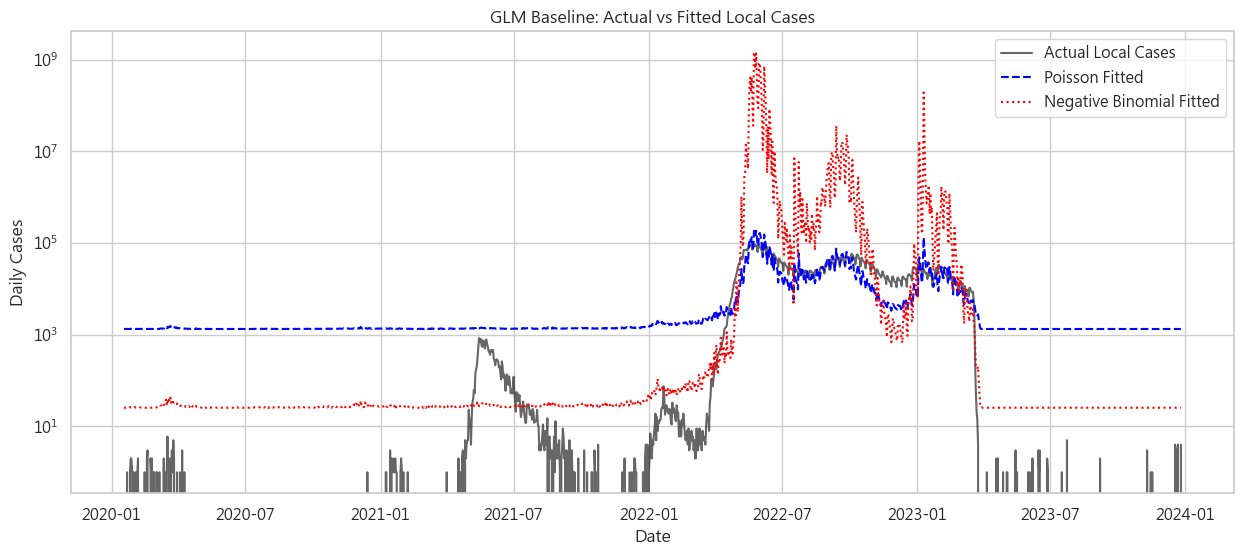

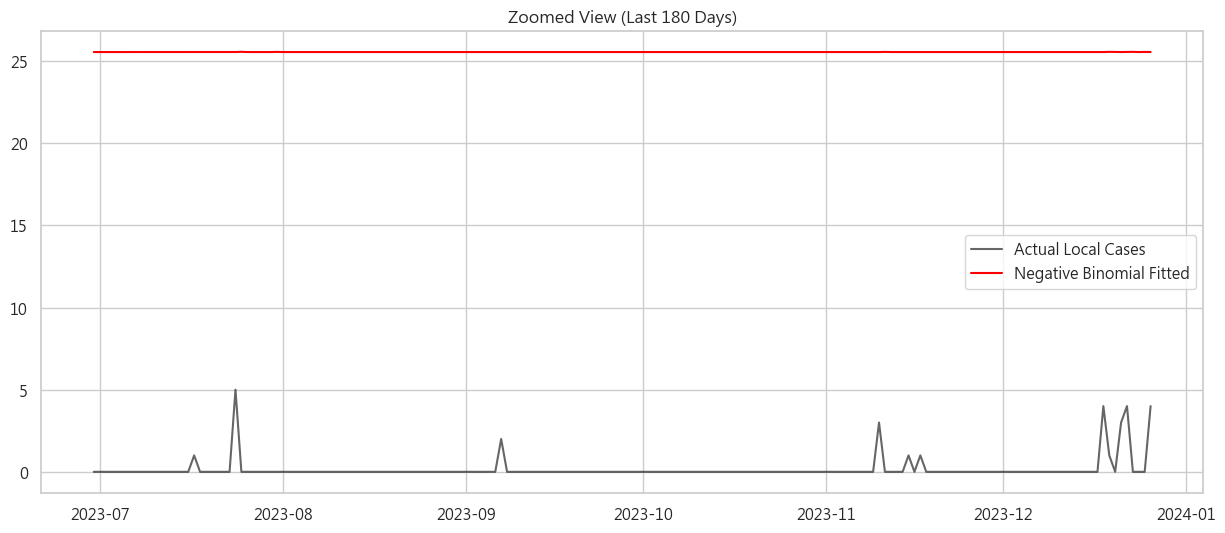

In [5]:
if 'df_model_clean' in locals():
    df_model_clean['pred_poisson'] = poisson_model.predict(df_model_clean)
    df_model_clean['pred_nb'] = nb_model.predict(df_model_clean)
    
    plt.figure(figsize=(15, 6))
    plt.plot(df_model_clean['date'], df_model_clean['local'], label='Actual Local Cases', color='black', alpha=0.6)
    plt.plot(df_model_clean['date'], df_model_clean['pred_poisson'], label='Poisson Fitted', color='blue', linestyle='--')
    plt.plot(df_model_clean['date'], df_model_clean['pred_nb'], label='Negative Binomial Fitted', color='red', linestyle=':')
    
    plt.title('GLM Baseline: Actual vs Fitted Local Cases')
    plt.xlabel('Date')
    plt.ylabel('Daily Cases')
    plt.legend()
    plt.yscale('log') # Log scale might successfully show the waves
    plt.show()
    
    # Zoom in to recent period
    latest_date = df_model_clean['date'].max()
    zoom_start = latest_date - pd.Timedelta(days=180)
    df_zoom = df_model_clean[df_model_clean['date'] > zoom_start]
    
    plt.figure(figsize=(15, 6))
    plt.plot(df_zoom['date'], df_zoom['local'], label='Actual Local Cases', color='black', alpha=0.6)
    plt.plot(df_zoom['date'], df_zoom['pred_nb'], label='Negative Binomial Fitted', color='red')
    plt.title(f'Zoomed View (Last 180 Days)')
    plt.legend()
    plt.show()